## Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

In [2]:
data = pd.read_csv("comments.tsv", sep='\t')

In [3]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [6]:
# preprocess each comment in train and test
texts_train = np.array([preprocess(text) for text in texts_train])
texts_test = np.array([preprocess(text) for text in texts_test])

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [7]:
# find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

frequency = { }
for word in ' '. join(texts_train).split():
    count = frequency.get(word, 0)
    frequency[word] = count + 1
frequency_vocabulary = dict(sorted(frequency.items(), key=lambda count: count[1], reverse=True)[:k])

bow_vocabulary = list(frequency_vocabulary.keys())
print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [8]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    counts = np.zeros(len(bow_vocabulary))
    for word in text.split():
        try:
            index = bow_vocabulary.index(word)
            counts[index] += 1
        except ValueError:
            continue
    return np.array(counts, 'float32')

In [9]:
texts_train[::200]

array(['... oh and what kind of person watches another persons mytalk page ? stalker !',
       'dcandeto smells funny ! he is very mean !',
       'caps seems like demon core should be capitalized'], dtype='<U5384')

In [10]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

### `sklearn` logistic regression implementation:

In [13]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

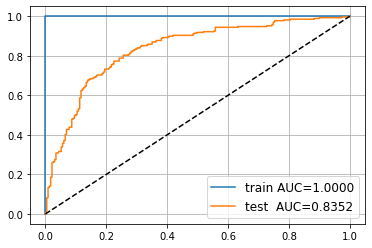

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using `PyTorch`. Just like in the classwork.

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [16]:
from utils import plot_train_process

In [17]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(X_train_bow.shape[-1], 2))

In [18]:
loss_function = nn.CrossEntropyLoss()

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=7e-4)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

In [20]:
X_train_bow_torch = torch.FloatTensor(X_train_bow)
X_test_bow_torch = torch.FloatTensor(X_test_bow)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

In [21]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # clear gradients
        opt.zero_grad()
        
        # compute loss
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()
        # Adam step
        opt.step()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

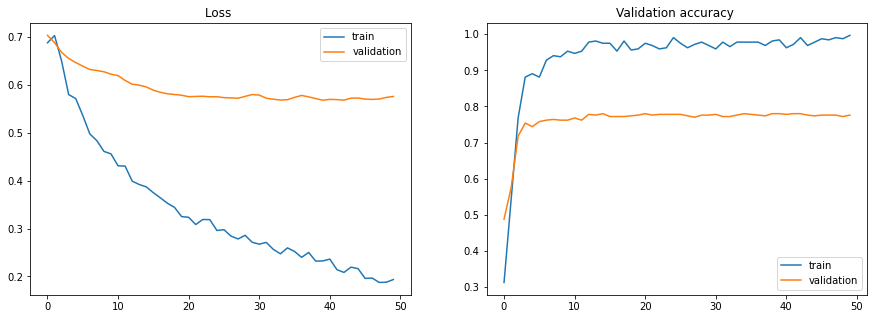

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

In [22]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

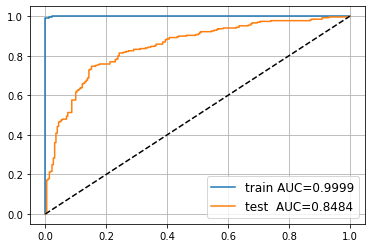

In [23]:
for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

In [24]:
k = min(10000, len(set(' '.join(texts_train).split())))

frequency = { }
for word in ' '. join(texts_train).split():
    count = frequency.get(word, 0)
    frequency[word] = count + 1
frequency_vocabulary_in_dataset = dict(sorted(frequency.items(), key=lambda count: count[1], reverse=True)[:k])

bow_vocabulary = list(frequency_vocabulary.keys())

In [25]:
frequency_in_document = { }
N = len(texts_train)
ALPHA = 1

for text in texts_train:
    for word in set(text.split()):
        if word in bow_vocabulary:
            count = frequency_in_document.get(word, 0)
            frequency_in_document[word] = count + 1

def text_to_tfidf(text):
    frequency_in_text = { }
    for word in text.split():
        count = frequency_in_text.get(word, 0)
        frequency_in_text[word] = count + 1
    counts = np.zeros(len(frequency_in_document))
    for word in text.split():
        try:
            index = bow_vocabulary.index(word)
            counts[index] = frequency_in_text[word] * np.log10(N / (frequency_in_document[word] + ALPHA))
        except ValueError:
            continue
    return np.array(counts, 'float32')

In [26]:
X_train_tfidf = np.stack(list(map(text_to_tfidf, texts_train)))
X_test_tfidf = np.stack(list(map(text_to_tfidf, texts_test)))

In [27]:
X_train_tfidf

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0215834 ,  0.7052311 ,  0.29756945, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11350928,  0.        ,  0.29756945, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.4540371 ,  1.1753851 ,  0.29756945, ...,  2.39794   ,
         0.        ,  0.        ],
       [ 3.9728246 ,  8.227695  , 10.414931  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22701855,  0.23507701,  0.        , ...,  0.        ,
         2.39794   ,  2.39794   ]], dtype=float32)

In [28]:
X_train_tfidf_torch = torch.FloatTensor(X_train_tfidf)
X_test_tfidf_torch = torch.FloatTensor(X_test_tfidf)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

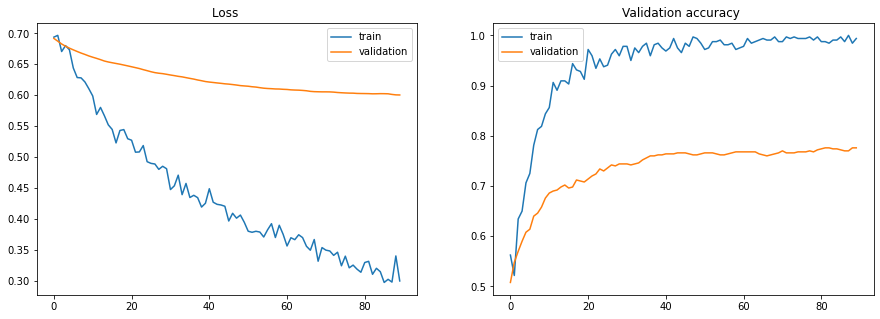

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

In [29]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(X_train_tfidf_torch.shape[-1], 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

epochs = 900

train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=epochs)

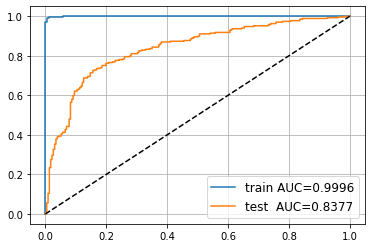

In [30]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, model),
    ('test ', X_test_tfidf_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 3: word2vec.

Use the `gensim` word2vec pretrained model to translate words into vectors.

In [31]:
import gensim.downloader as api

In [32]:
word2vec = api.load("word2vec-google-news-300")

In [33]:
vec_shape = word2vec.get_vector("hi").shape

In [34]:
def text_to_vec(text):
    vec = []
    for word in text.split():
        if word in word2vec.vocab:
            vec.append(word2vec.get_vector(word))
    if not vec:
        return np.zeros(300, 'float32')
    vec = np.mean(vec, axis=0)
    if np.linalg.norm(vec) != 0:
        return np.array(vec / np.linalg.norm(vec), 'float32')
    return vec

In [35]:
X_train_word2vec = np.stack(list(map(text_to_vec, texts_train)))
X_test_word2vec = np.stack(list(map(text_to_vec, texts_test)))

In [37]:
X_train_word2vec_torch = torch.FloatTensor(X_train_word2vec)
X_test_word2vec_torch = torch.FloatTensor(X_test_word2vec)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

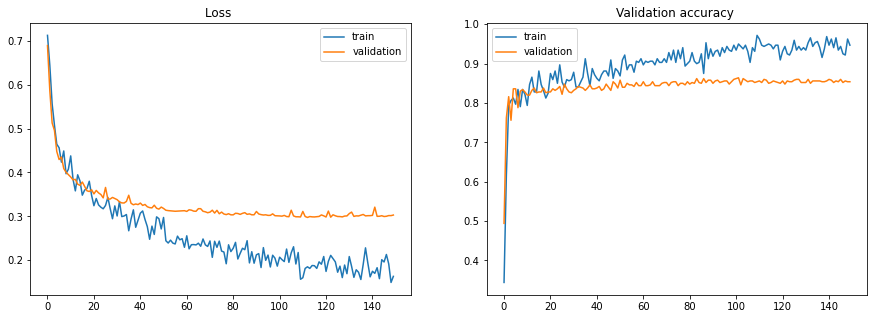

Sequential(
  (l1): Linear(in_features=300, out_features=2, bias=True)
)

In [38]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(X_train_word2vec_torch.shape[-1], 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

epochs = 1500

train_model(model, opt, lr_scheduler, X_train_word2vec_torch, y_train_torch, X_test_word2vec_torch, y_test_torch, n_iterations=epochs)

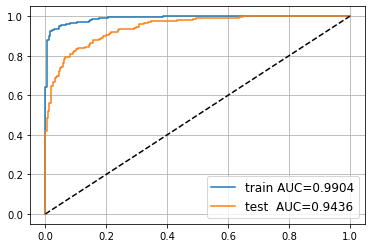

In [39]:
for name, X, y, model in [
    ('train', X_train_word2vec_torch, y_train, model),
    ('test ', X_test_word2vec_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()